### Libraries

In [122]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from difflib import get_close_matches
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_curve, roc_auc_score, confusion_matrix, f1_score 
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from copy import deepcopy
from sqlalchemy import create_engine
from scipy import stats
%config InlineBackend.figure_format = 'svg'
#%matplotlib inline

In [ ]:
connection_args = {
    'host': '18.188.170.26', # You'll have to update this to your IP
    'user': 'ubuntu',    # username
    'dbname': 'mcnulty',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}
connection = pg.connect(**connection_args)
cursor = connection.cursor()

### Functions

In [2]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# Function used to plot the learning curve, roc curve, and confusing matrix for the given model
def plot_model(model, X, y):
    model.fit(X, y)
    y_predict = model.predict(X)
    y_predictprob = model.predict_proba(X)[:, 1]

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 10)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 10)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')

    m, train_err, test_err = learning_curve(model, X, y, cv = 10, scoring = 'f1', random_state = 42)
    m_trainerr = np.mean(train_err, axis = 1)
    m_testerr = np.mean(test_err, axis = 1)

    fpr, tpr, thr = roc_curve(y, y_predictprob)

    plt.rcParams.update({'figure.figsize': (15, 6)})
    plt.subplot(1,2,1)
    plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
    plt.xlabel('Number of Samples', fontsize = 14)
    plt.ylabel('F1', fontsize = 14)
    plt.legend(['Training Error', 'Test Error'])
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr)
    print(f'AUC: {np.round(roc_auc_score(y_train, y_predictprob), 4)}')

    conf_mat = confusion_matrix(y_train, y_predict)
    cm = print_confusion_matrix(conf_mat, ['CS', 'SB'])
    
    return LR_f1

# Function to do pseudo fuzzy matching between the names in the hitter/pitcher tables and the steal table
def matches(x, col, n, th):
    if get_close_matches(x, col, n, th) == []:
        return ''
    else:
        return get_close_matches(x, col, n, th)[0]

# Function that determines which columns are beneficial to drop by dropping each column individually, getting
# the cross-validated score, and sorts to see dropping which column contributes to the best f1. This process 
# continues until the process of dropping columns isn't beneficial to the f1 score.
def model_dropcols_opt(model, X, y, basef1, ncv, print_f1s = False):
    
    # feature columns that get dropped from X because when dropped
    # they cause f1 to increase or not change at all
    
    cols_drop = []
    counter = 0
    best_delta = ('name', 1)
    while best_delta[1] >= 0:
        
        if counter > len(X.columns) - 2:
            break
        
        deltas = []
        
        for i in X.columns:

            f1_cval = np.round(np.mean(cross_val_score(model, X.drop(columns = i), y, scoring = 'f1', cv = ncv)), 5)
            deltas.append((i, f1_cval - basef1))
        
        deltas_sort = sorted(deltas, key = lambda x: x[0], reverse = True)
        best_delta = deltas_sort[0]
        
        if print_f1s == True:
            print(best_delta)
            
        if best_delta[1] >= 0:
            cols_drop.append(best_delta[0])
            X = X.drop(columns = best_delta[0])
            
    return cols_drop

# Performs a boxcox transform for a given dataframe column, ep is a small value added to all entries so that
# the log(0) isn't performed
def bc_transform(col, ep):
    lamb = stats.boxcox_normmax(col.apply(lambda x: x + ep), brack=(-3, 3))
    return (lamb, col.apply(lambda x: stats.boxcox(x + ep, lamb)))

# Performs a boxcox transform on an entire dataframe for specified columns
def bc_df(df, cols, ep):
    
    copy_df = deepcopy(df)
    
    all_lambdas = {}
    
    for c in cols:
        output = bc_transform(copy_df[c], ep)
        all_lambdas[c] = output[0]
        copy_df[f'bc_{c}'] = output[1]
    
    return (all_lambdas, copy_df)

### Create Tables (SQL)

Autopopulate the create table query with the proper column names and column types from the table schema file:

In [ ]:
with open('./Data/gw_tblschema.csv', mode = 'r') as filename:
    cols = filename.read()
    filename.close()
    
cols_list = [i.split(',')[1:3] for i in cols.split('\n')[1:-1]]
cols_text = ''
for i, txt in enumerate(cols_list):
    name = txt[0]
    col_type = txt[1]
    if col_type == 'STRING':
        col_type = 'TEXT'
    elif col_type == 'INTEGER':
        col_type = 'INT'
        
    if i == len(cols_list) - 1:
        cols_text += f'{name} {col_type}'
    else:
        cols_text += f'{name} {col_type}, '

Create baseball and gamepostwide tables in the SQL server:

In [ ]:
create_tblquery = f""" 
    CREATE TABLE baseball(
        row INT, 
        {cols_text}
    );"""

create_postwidetablequery = f""" 
    CREATE TABLE gamepostwide(
        row INT, 
        {cols_text}
    );"""

# cursor.execute('BEGIN;')
# cursor.execute(create_tblquery)
# cursor.execute(create_postwidetablequery)
# cursor.execute('commit;')

Create steal view for baseball table

In [ ]:
steal_columns = ['gameid', 'daynight', 'venueid', 'venuename', 'venuesurface',
            'venueoutfielddistances', 'inningnumber', 'inninghalf', 'inninghalfeventsequencenumber',
            'hitterbathand', 'pitcherid', 'pitcherthrowhand', 'pitchtype', 'pitchtypedescription',
            'pitchspeed', 'pitchzone', 'pitcherpitchcount', 'hitterpitchcount', 'balls',
          'strikes', 'outs', 'homecurrenttotalruns', 'awaycurrenttotalruns',
          'rob1_start', 'rob1_end', 'rob1_isout', 'rob1_outcomeid', 'rob1_outcomedescription',
          'rob2_start', 'rob2_end', 'rob2_isout', 'rob2_outcomeid', 'rob2_outcomedescription',
          'rob3_start', 'rob3_end', 'rob3_isout', 'rob3_outcomeid', 'rob3_outcomedescription',
          'is_bunt', 'is_bunt_shown', 'is_double_play', 'is_triple_play', 'is_wild_pitch']
steal_columns_str = str(steal_columns).replace('[','').replace(']', '').replace("'", '')

create_stealview = f"""
    CREATE VIEW steals AS
    (SELECT {steal_columns_str}
    FROM baseball
    WHERE rob1_outcomeid LIKE '%CS%'
    OR rob1_outcomeid LIKE '%SB%'
    OR rob2_outcomeid LIKE '%CS%'
    OR rob2_outcomeid LIKE '%SB%'
    OR rob3_outcomeid LIKE '%CS%'
    OR rob3_outcomeid LIKE '%SB%'
    ORDER BY gameid, starttime, inningnumber, inninghalfeventsequencenumber);
"""

# cursor.execute('BEGIN;')
# cursor.execute(create_stealview)
# cursor.execute('commit;')

Non perfect information steal table

In [ ]:
rsteal_columns = ['gameid', 'daynight', 'venueid', 'venuename', 'venuesurface',
            'venueoutfielddistances', 'inningnumber', 'inninghalf', 'inninghalfeventsequencenumber', 
            'hitterbathand','pitcherthrowhand', 'pitcherpitchcount', 'hitterpitchcount', 'balls',
          'strikes', 'startingouts', 'homecurrenttotalruns', 'awaycurrenttotalruns',
          'rob1_start', 'rob1_end', 'rob1_isout', 'rob1_outcomeid', 'rob1_outcomedescription',
          'rob2_start', 'rob2_end', 'rob2_isout', 'rob2_outcomeid', 'rob2_outcomedescription',
          'rob3_start', 'rob3_end', 'rob3_isout', 'rob3_outcomeid', 'rob3_outcomedescription',
        'is_bunt_shown']
rsteal_columns_str = str(rsteal_columns).replace('[','').replace(']', '').replace("'", '')

create_rstealview = f"""
    CREATE VIEW real_steals AS
    (SELECT {rsteal_columns_str},
    CONCAT(hitterfirstname, ' ', hitterlastname) AS hittername,
    CONCAT(pitcherfirstname, ' ', pitcherlastname) AS pitchername
    FROM baseball
    WHERE rob1_outcomeid LIKE '%CS%'
    OR rob1_outcomeid LIKE '%SB%'
    OR rob2_outcomeid LIKE '%CS%'
    OR rob2_outcomeid LIKE '%SB%'
    OR rob3_outcomeid LIKE '%CS%'
    OR rob3_outcomeid LIKE '%SB%'
    ORDER BY gameid, starttime, inningnumber, inninghalfeventsequencenumber);
"""

cursor.execute('BEGIN;')
cursor.execute(create_rstealview)
cursor.execute('commit;')


Create the hitter table using the csv file from fangraphs

In [ ]:
hitter_df = pd.read_csv('/Data/hitter_platedisp_fangraphs.csv')

hitterdf_new_names = {'O-Swing%': 'o_swing_per',
            'Z-Swing%': 'z_swing_per',
            'Swing%': 'swing_per',
            'O-Contact%': 'o_contact_per',
            'Z-Contact%': 'z_contact_per',
            'Contact%': 'contact_per',
            'Zone%': 'zone_per',
            'F-Strike%': 'f_strike_per',
            'SwStr%': 'swstr_per'}
hitter_df.rename(hitterdf_new_names, axis = 1, inplace = True)
hitter_df = hitter_df.applymap(str).applymap(lambda x: x.replace('%', '').strip())
hitter_df.iloc[:, 2:] = hitter_df.iloc[:, 2:].applymap(float)

connection_string = f'postgres://ubuntu:{connection_args["host"]}@{connection_args["host"]}:{connection_args["port"]}/{connection_args["dbname"]}'
engine = create_engine(connection_string)
#hitter_df.to_sql('hitters', engine, index=False)

Create the pitcher table using the csv file from fangraphs

In [ ]:
pitcher_df = pd.read_csv('/Data/pitcher_pitchstats_fangraphs.csv')

pitcherdf_new_names = {'FB%': 'FB_per',
                     'SL%': 'SL_per',
                     'CT%': 'CT_per',
                     'CB%': 'CB_per',
                     'CH%': 'CH_per',
                     'SF%': 'SF_per',
                     'KN%': 'KN_per',
                     'XX%': 'XX_per'}

pitcher_df.rename(pitcherdf_new_names, axis = 1, inplace = True)
pitcher_df.fillna(0, inplace = True)
pitcher_df = pitcher_df.applymap(str).applymap(lambda x: x.replace('%', '').strip())
pitcher_df.iloc[:, 2:] = pitcher_df.iloc[:, 2:].applymap(float)
#pitcher_df.to_sql('pitchers', engine, index=False)

### Not Perfect Information

#### EDA

In [ ]:
# Query for real_steal view table
rsteal_query = """
    SELECT *
    FROM real_steals ;
"""
rsteal_df = pd_sql.read_sql(rsteal_query, connection)
rsteal_df['all_outcomes'] = (rsteal_df[['rob1_outcomeid', 'rob2_outcomeid', 'rob3_outcomeid']]
 .fillna('')
 .apply(lambda x: ''.join(x), axis = 1))

#plan to drop any caught stealing rows where pickoffs happen
rsteal_df['is_pickoff'] = rsteal_df['all_outcomes'].apply(lambda x: 1 if x.find('PO') >= 0 else 0)
rsteal_df = rsteal_df.where(rsteal_df['is_pickoff'] == 0).dropna(how = 'all')
rsteal_df.drop(columns = 'is_pickoff', inplace = True)

# if both stolen base and caught stealing happen at the same time, will count toward stolen base
rsteal_df['is_steal'] = rsteal_df['all_outcomes'].apply(lambda x: 1 if x.find('SB') >= 0 else 0)
rsteal_df.to_pickle('real_stealtable.pkl')

In [ ]:
# read steal data from generated pickle file
rsteal_df = pd.read_pickle('real_stealtable.pkl')

# query to select all data from the hitter SQL table
hitter_query = """
    SELECT *
    FROM hitters;
"""
hitter_df = pd_sql.read_sql(hitter_query, connection)
# uses pseudo-fuzzy logic to find the closest match in the names given in rsteal_df to the names listed in
# hitter_df. This is used primarily for nicknames/shortened names
hitter_df['hittername'] = hitter_df['Name'].apply(lambda x: matches(x, rsteal_df['hittername'], 1, 0.7))
hitter_df.to_pickle('hitter.pkl')

# query to select all data from the pitcher SQL table
pitcher_query = """
    SELECT *
    FROM pitchers;
"""
pitcher_df = pd_sql.read_sql(pitcher_query, connection)
# uses pseudo-fuzzy logic to find the closest match in the names given in rsteal_df to the names listed in
# pitcher_df. This is used primarily for nicknames/shortened names
pitcher_df['pitchername'] = pitcher_df['Name'].apply(lambda x: matches(x, rsteal_df['pitchername'], 1, 0.7))
pitcher_df.to_pickle('pitcher.pkl')

Read data from the pickle files generated from the SQL databae queries, epsilon is a parameter used for the boxcox transformations

In [3]:
rsteal_df = pd.read_pickle('real_stealtable.pkl')
hitter_df = pd.read_pickle('hitter.pkl')
pitcher_df = pd.read_pickle('pitcher.pkl')
ep = 0.00001

Boxcox transformation of the numeric columns of the hitter and pitcher dataframes

In [6]:
hitter_num_cols = hitter_df.columns[2:-2]
hitter_lambda, hitter_df = bc_df(hitter_df, hitter_num_cols, ep)

pitcher_num_cols = pitcher_df.columns[2:-2]
pitcher_lambda, pitcher_df = bc_df(pitcher_df, pitcher_num_cols, ep)

In [161]:
# Merging the rsteal dataframe with the pitcher and hitter dfs on the shared player names
total_df = rsteal_df.merge(pitcher_df.drop(['Name', 'Team', 'playerid'], axis = 1), how = 'left', on = 'pitchername')
total_df = total_df.merge(hitter_df.drop(['Name', 'Team', 'playerid'], axis = 1), how = 'left', on = 'hittername')

# Dummifying all of the categorical variables contained in rsteal_df
total_df['is_day'] = total_df['daynight'].apply(lambda x: 1 if x == 'N' else 0)
total_df['is_grass'] = total_df['venuesurface'].apply(lambda x: 1 if x == 'grass' else 0)
total_df['is_home'] = total_df['inninghalf'].apply(lambda x: 1 if x == 'BOT' else 0)
total_df['is_batterR'] = total_df['hitterbathand'].apply(lambda x: 1 if x == 'R' else 0)
total_df['is_batterL'] = total_df['hitterbathand'].apply(lambda x: 1 if x == 'L' else 0)
total_df['is_pitcherR'] = total_df['pitcherthrowhand'].apply(lambda x: 1 if x == 'R' else 0)
total_df['all_onbase'] = total_df[['rob1_end', 'rob2_end', 'rob3_end']].apply(lambda x: tuple(x), axis = 1)
total_df['is_rob1'] = total_df['all_onbase'].apply(lambda x: 1 if x[0] > 1 else 0)
total_df['is_rob2'] = total_df['all_onbase'].apply(lambda x: 1 if x[0] > 2 else 0)
total_df['is_rob3'] = total_df['all_onbase'].apply(lambda x: 1 if x[0] > 3 else 0)

# Saving pickle files that will be used in the flask app for hitter and pitcher input
hitter_df.to_pickle('./Flask/model/hitter_input.pkl')
pitcher_input_df = pitcher_df.merge(total_df[['pitchername', 'is_pitcherR']], how = 'left', on = 'pitchername')
pitcher_input_df['is_pitcherR'].fillna('1', inplace = True)
pitcher_input_df = pitcher_input_df.groupby(['Name', 'Team', 'is_pitcherR'], as_index = False).median()
pitcher_input_df.to_pickle('./Flask/model/pitcher_input.pkl')

# Categorical text columns that need to be dropped as model only takes in numeric features
drop_cols = ['gameid', 'daynight', 'venueid', 'venuename', 'venuesurface',
            'venueoutfielddistances', 'inninghalf', 'inninghalfeventsequencenumber', 'hitterbathand',
            'pitcherthrowhand', 'rob1_start', 'rob1_end', 'rob1_isout', 'rob1_outcomeid', 'rob1_outcomedescription',
            'rob2_start', 'rob2_end', 'rob2_isout', 'rob2_outcomeid', 'rob2_outcomedescription',
            'rob3_start', 'rob3_end', 'rob3_isout', 'rob3_outcomeid', 'rob3_outcomedescription',
            'all_outcomes', 'all_onbase', 'hittername', 'pitchername']

total_df.drop(columns = drop_cols, inplace = True)
total_df.head()

,inningnumber,pitcherpitchcount,hitterpitchcount,balls,strikes,startingouts,homecurrenttotalruns,awaycurrenttotalruns,is_bunt_shown,is_steal,...,bc_swstr_per,is_day,is_grass,is_home,is_batterR,is_batterL,is_pitcherR,is_rob1,is_rob2,is_rob3
0,8.0,19.0,2.0,1.0,1.0,1.0,5.0,5.0,0.0,1,...,2.888626,1,1,0,0,0,1,1,0,0
1,1.0,14.0,3.0,2.0,1.0,1.0,0.0,1.0,0.0,1,...,3.501533,1,1,0,1,0,0,1,0,0
2,1.0,20.0,4.0,3.0,1.0,1.0,0.0,1.0,0.0,0,...,2.291253,1,1,0,1,0,0,0,0,0
3,1.0,20.0,4.0,3.0,1.0,1.0,0.0,1.0,0.0,0,...,3.501533,1,1,0,1,0,0,0,0,0
4,4.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,1,...,4.262781,1,1,1,1,0,0,1,0,0


In [9]:
# Establishing X and y
y = total_df['is_steal']
X = total_df.drop(columns = ['is_steal'])
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
# Imputing nan values in each column using the median of the training data for those columns
fill_cols = [X_train.columns[i] for i, val in enumerate(X_train.isna().sum()) if val > 0]
# Saving median values separately as the same values have to be used to impute the test data
median_vals = X_train[fill_cols].median()

for i, med in enumerate(median_vals):
    column_label = median_vals.index[i]
    X_train[column_label].fillna(med, inplace = True)
    X_test[column_label].fillna(med, inplace = True)

# Standard scaling of the train and test data
r_ssX = StandardScaler()
X_train_scaled = pd.DataFrame(r_ssX.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(r_ssX.fit_transform(X_test), columns = X_test.columns)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### Dummy Classifier

The base LR accuracy is: 0.60799
The base LR f1 is: 0.7493
AUC: 0.4923


0.7493

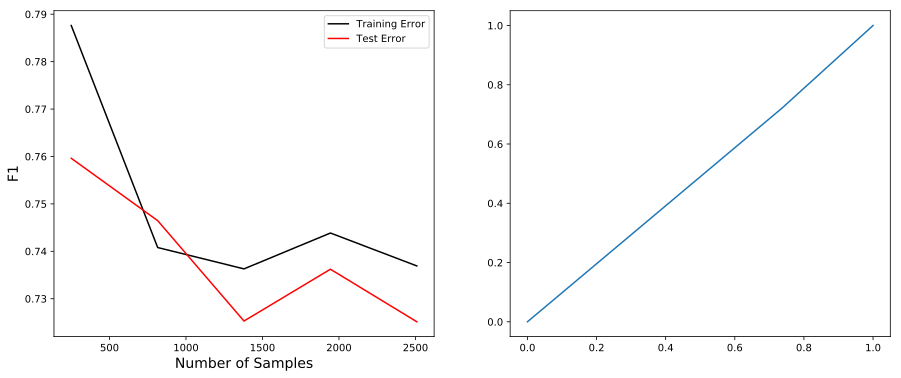

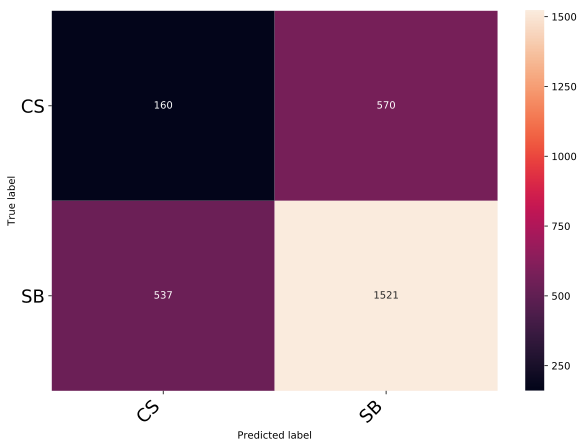

In [141]:
DC = DummyClassifier(strategy = 'stratified')
plot_model(DC, X_train_scaled, y_train)

#### Logistic Regression

Base logistic regression

The base LR accuracy is: 0.90387
The base LR f1 is: 0.93258
AUC: 0.9665


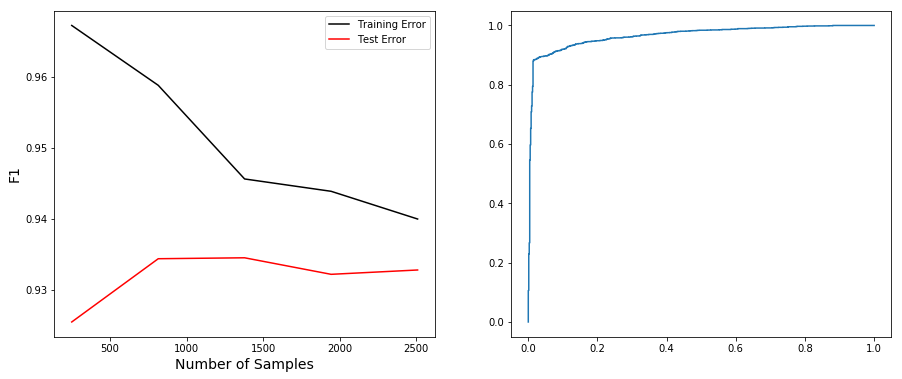

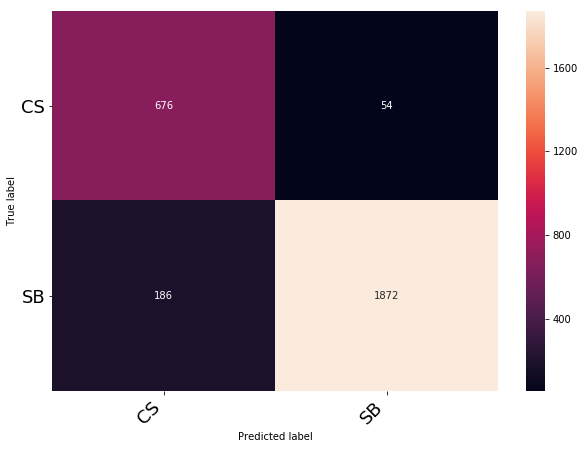

In [12]:
LR = LogisticRegression(random_state= 42)
rLR_basef1 = plot_model(LR, X_train_scaled, y_train)

First set of columns to drop

In [13]:
LR_colsdrop = model_dropcols_opt(LR, X_train_scaled, y_train, rLR_basef1, 10, True)

('zone_per', 0.00024000000000001798)
('z_swing_per', 0.0007800000000000029)
('z_contact_per', 0.0009299999999999864)
('swstr_per', 0.0009799999999999809)
('swing_per', 0.0005100000000000104)
('strikes', 0.0012500000000000844)
('startingouts', -0.0006399999999999739)


Refitting based on dropping those initial columns

The base LR accuracy is: 0.90566
The base LR f1 is: 0.93383
AUC: 0.9661


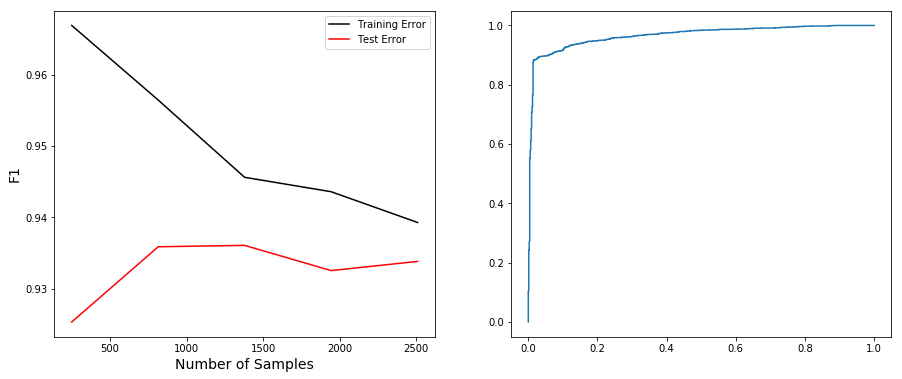

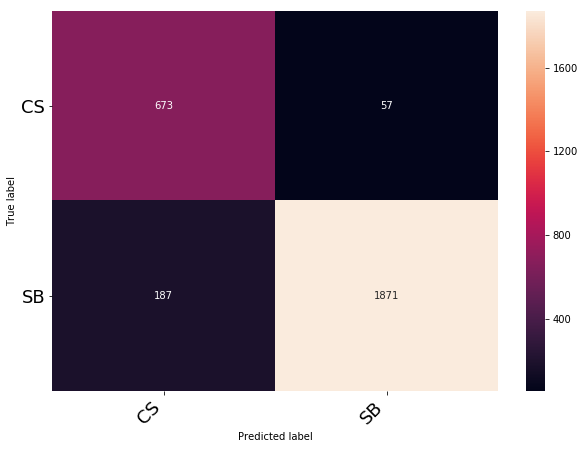

In [14]:
LR_Xtrain_scaled = X_train_scaled.drop(LR_colsdrop, axis = 1)
rLR_secondf1 = plot_model(LR, LR_Xtrain_scaled, y_train)

Grid search on C after dropping those initial columns

In [ ]:
LRparam_grid = {'C': np.arange(2.3, 2.5, 0.01)}
LR_grid = GridSearchCV(LR, LRparam_grid, scoring = 'f1', cv = 10)
LR_grid.fit(LR_Xtrain_scaled, y_train)
print(LR_grid.best_params_)
print(LR_grid.best_score_)

Best C parameter was found to be 2.32, refitting model based on updated C

The base LR accuracy is: 0.90638
The base LR f1 is: 0.9344
AUC: 0.9666


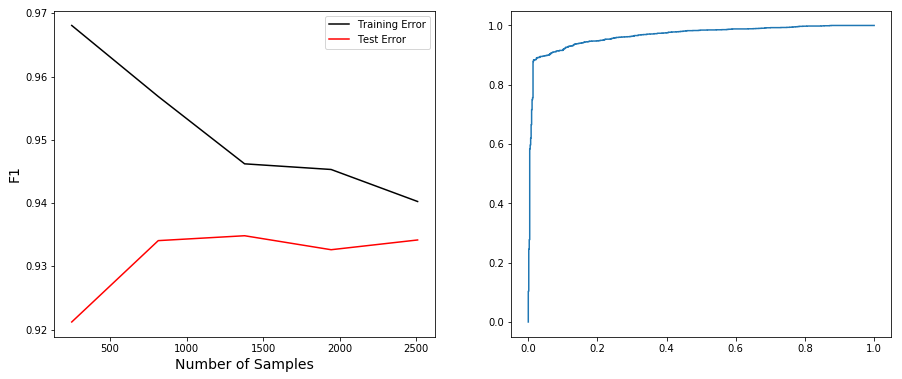

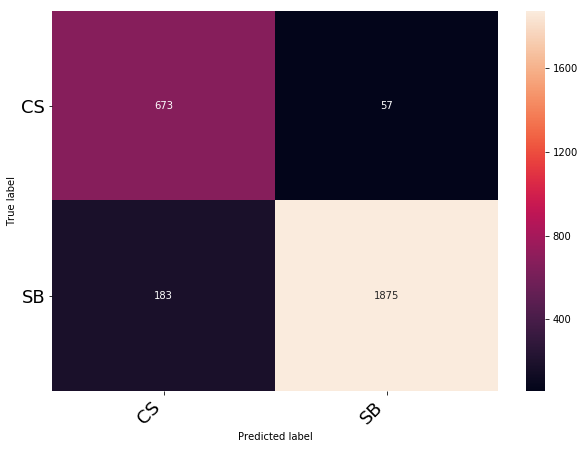

In [15]:
LR = LogisticRegression(C = 2.32, random_state = 42)
rLR_optf1 = plot_model(LR, LR_Xtrain_scaled, y_train)

Utilizing more aggressive cut based on model coefficients to determine additional features to remove from the model

In [16]:
LR = LogisticRegression(C = 2.32, random_state = 42)
LR.fit(LR_Xtrain_scaled, y_train)
LRimportances = sorted([(i, j) for i, j in zip(LR_Xtrain_scaled.columns, LR.coef_[0])],
       key = lambda x: abs(x[1]), reverse = True)

LR_drops = [i[0] for i in LRimportances if abs(i[1]) < 0.25]
LR_drops

['inningnumber',
 'homecurrenttotalruns',
 'SF_per',
 'CT_per',
 'XX_per',
 'bc_CT_per',
 'is_batterR',
 'bc_SL_per',
 'bc_swstr_per',
 'pitcherpitchcount',
 'is_day',
 'balls',
 'bc_XX_per',
 'bc_o_contact_per',
 'SLv',
 'bc_CBv',
 'bc_CHv',
 'SL_per',
 'FB_per',
 'CBv',
 'is_grass',
 'is_bunt_shown',
 'bc_FB_per',
 'bc_FBv',
 'bc_KN_per',
 'KNv',
 'KN_per',
 'bc_KNv',
 'bc_SLv',
 'is_rob3',
 'awaycurrenttotalruns',
 'FBv',
 'is_batterL',
 'is_home']

The base LR accuracy is: 0.90961
The base LR f1 is: 0.93628
AUC: 0.9625


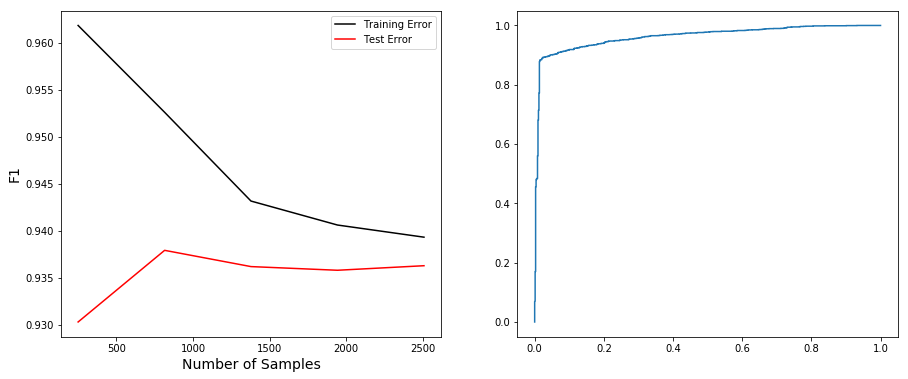

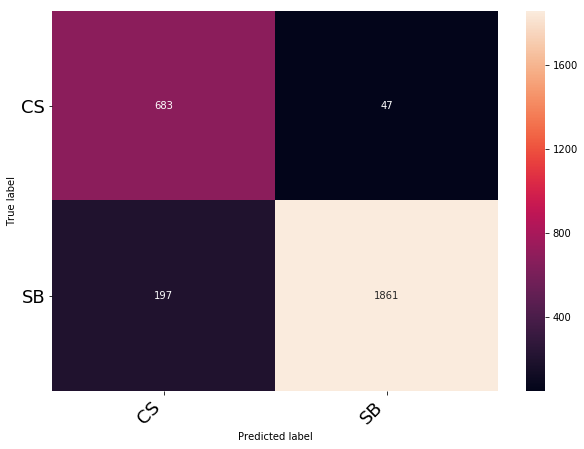

In [17]:
LR_Xtrain_scaled2 = LR_Xtrain_scaled.drop(LR_drops, axis = 1)
LR = LogisticRegression(C = 2.32, random_state = 42)
rLR_thirdf1 = plot_model(LR, LR_Xtrain_scaled2, y_train)

In [18]:
LR = LogisticRegression(C = 2.32, random_state = 42)
LR.fit(LR_Xtrain_scaled2, y_train)
sorted([(i, j) for i, j in zip(LR_Xtrain_scaled2.columns, LR.coef_[0])],
       key = lambda x: abs(x[1]), reverse = True)

[('is_rob1', 3.0452800065345316),
 ('bc_swing_per', -1.4077825868615168),
 ('bc_contact_per', -1.2326528662588176),
 ('bc_o_swing_per', 1.0932088830287174),
 ('bc_f_strike_per', -0.8823531179994617),
 ('f_strike_per', 0.8210553592049129),
 ('bc_z_swing_per', 0.8048322489856142),
 ('CH_per', -0.7547697420131612),
 ('bc_CH_per', 0.6680985334848657),
 ('bc_SF_per', -0.6587198006118506),
 ('bc_SFv', 0.6073833962947187),
 ('bc_zone_per', 0.5263944485494165),
 ('contact_per', 0.525071119120706),
 ('CTv', -0.5101262273809692),
 ('is_pitcherR', -0.5030467390331308),
 ('is_rob2', 0.4295152215161041),
 ('o_contact_per', 0.41240134691954294),
 ('bc_CTv', 0.41119266618169836),
 ('bc_z_contact_per', 0.3880673750756738),
 ('CB_per', -0.3793936372077518),
 ('startingouts', 0.3480737112531649),
 ('o_swing_per', -0.27752188168472713),
 ('CHv', -0.2457983024070283),
 ('bc_CB_per', 0.2106723885505323),
 ('hitterpitchcount', -0.18420434888945972),
 ('SFv', 0.0748408102000166)]

In [ ]:
LR = LogisticRegression(random_state = 42)
LRparam_grid = {'C': np.arange(4.95, 5.1, 0.01)}
LR_grid = GridSearchCV(LR, LRparam_grid, scoring = 'f1', cv = 10)
LR_grid.fit(LR_Xtrain_scaled2, y_train)
print(LR_grid.best_params_)
print(LR_grid.best_score_)

The base LR accuracy is: 0.91069
The base LR f1 is: 0.93712
AUC: 0.9627


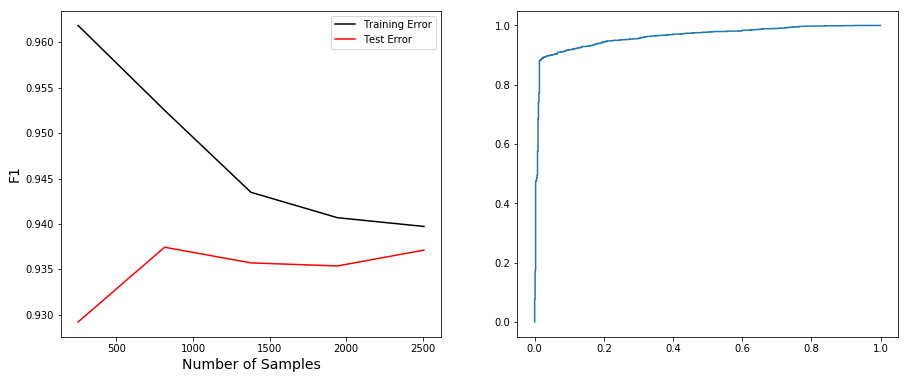

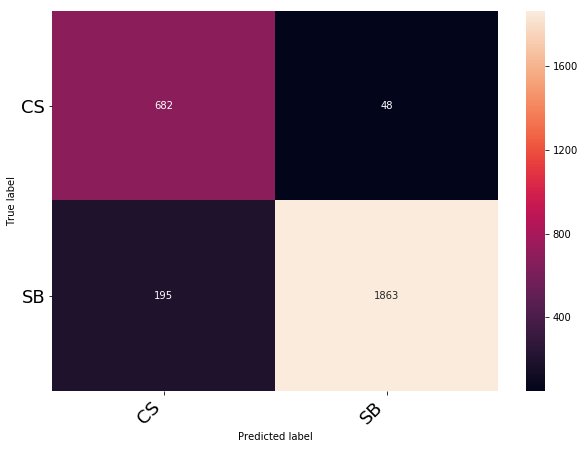

In [19]:
LR = LogisticRegression(C = 5.01, random_state = 42)
rLR_fourthf1 = plot_model(LR, LR_Xtrain_scaled2, y_train)

In [20]:
LR = LogisticRegression(C = 5.01, random_state = 42)
LR.fit(LR_Xtrain_scaled2, y_train)
LRimportances2 = sorted([(i, j) for i, j in zip(LR_Xtrain_scaled2.columns, LR.coef_[0])],
       key = lambda x: abs(x[1]), reverse = True)

LR_drops2 = [i[0] for i in LRimportances2 if abs(i[1]) < 0.25]
LR_drops2

['bc_CB_per', 'hitterpitchcount', 'SFv']

In [142]:
LRimportances2

[('is_rob1', 3.089482276723028),
 ('bc_swing_per', -1.7377425291156403),
 ('bc_contact_per', -1.4079880272783154),
 ('bc_o_swing_per', 1.3964317318262238),
 ('bc_f_strike_per', -1.2335158370116015),
 ('f_strike_per', 1.1759135497616469),
 ('bc_z_swing_per', 1.0080509564462108),
 ('CH_per', -0.8260022597261499),
 ('bc_CH_per', 0.7453463385370844),
 ('bc_SF_per', -0.6799204449621749),
 ('contact_per', 0.6349376730015187),
 ('bc_SFv', 0.6252232383655323),
 ('bc_zone_per', 0.6239972774389374),
 ('is_rob2', 0.5449482632198079),
 ('CTv', -0.5363156916950238),
 ('is_pitcherR', -0.505587974582459),
 ('o_contact_per', 0.4572408840672044),
 ('bc_CTv', 0.43794301597556046),
 ('bc_z_contact_per', 0.4289767056148141),
 ('CB_per', -0.39123098554930413),
 ('o_swing_per', -0.37414730180070443),
 ('startingouts', 0.3513629475276633),
 ('CHv', -0.26761242998755214),
 ('bc_CB_per', 0.21834383150675538),
 ('hitterpitchcount', -0.1868984814947727),
 ('SFv', 0.07429358459179927)]

The base LR accuracy is: 0.91104
The base LR f1 is: 0.93741
AUC: 0.9621


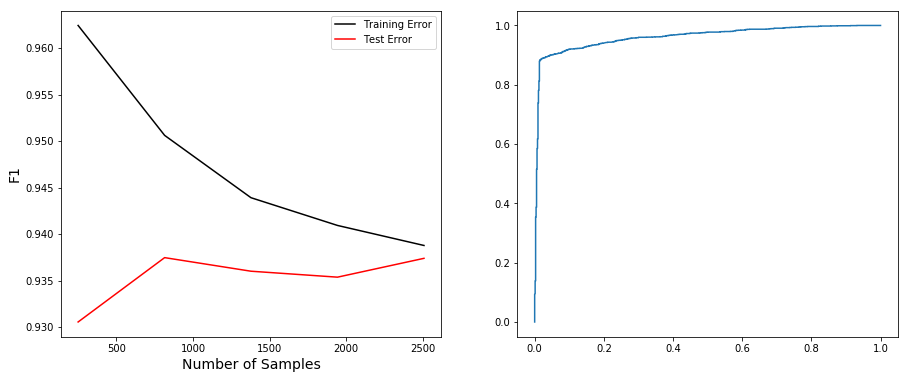

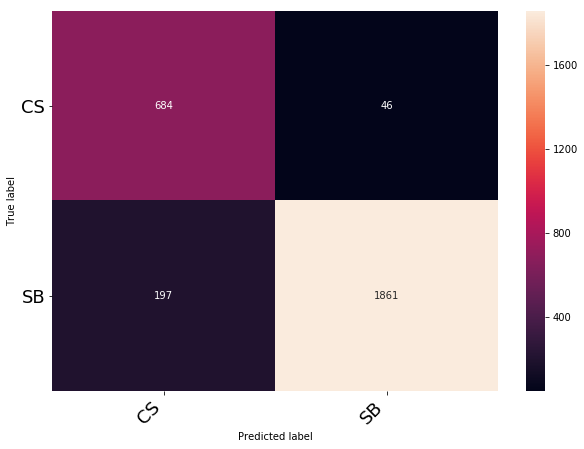

In [21]:
LR_Xtrain_scaled3 = LR_Xtrain_scaled2.drop(LR_drops2, axis = 1)
LR = LogisticRegression(C = 5.01, random_state = 42)
rLR_fifthf1 = plot_model(LR, LR_Xtrain_scaled3, y_train)

#### Models Grid Search

In [ ]:
KNN = KNeighborsClassifier()
RF = RandomForestClassifier(random_state = 42)
GB = GradientBoostingClassifier(random_state = 42)

r_models = [KNN, RF, GB]
r_names = ['KNN', 'RF', 'GB']

param_grid = [
    {'n_neighbors': np.arange(3, 20, 1)},
    {
        'n_estimators': [50, 100, 500],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {   
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.01, 0.1, 1],
        'n_estimators': [50, 100, 500],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]
             

grid_acc = {}

for n, m, gr in zip(r_names, r_models, param_grid):
    
    grid = GridSearchCV(m, gr, scoring = 'f1', cv = 5)
    grid.fit(X_train_scaled, y_train)
    grid_acc[n] = grid
    print((n, grid.best_score_))




In [ ]:
GB = GradientBoostingClassifier(loss = 'exponential', random_state = 42)
GB_paramgrid = {
    
    'learning_rate': [0.01],
    'n_estimators': [300, 400, 500, 600, 700],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [6, 7, 8]
    
    }

GBgrid = GridSearchCV(GB, GB_paramgrid, scoring = 'f1', cv = 5)
GBgrid.fit(LR_Xtrain_scaled, y_train)
print(GBgrid.best_params_)
print(GBgrid.best_score_)

The base LR accuracy is: 0.91069
The base LR f1 is: 0.93714
AUC: 0.9963


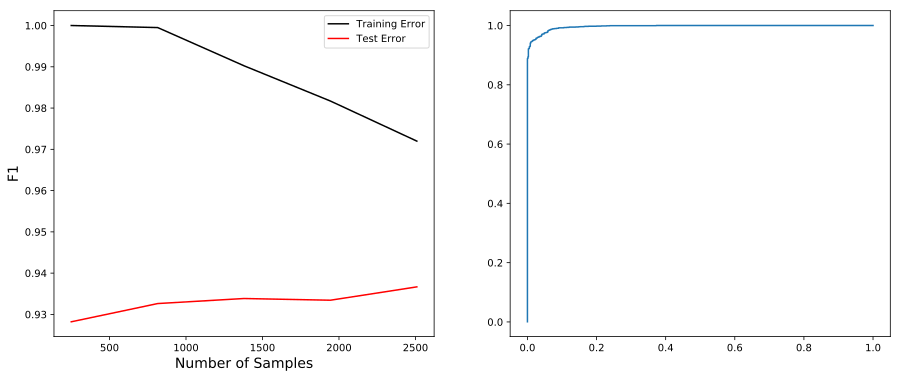

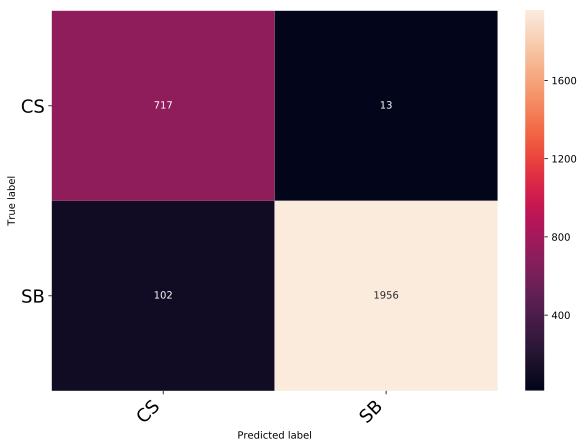

In [136]:
GB = GradientBoostingClassifier(loss = 'exponential', random_state = 42, learning_rate = 0.01,
                               n_estimators = 600, max_depth = 5, min_samples_leaf = 7)
rGB_basef1 = plot_model(GB, X_train_scaled, y_train)

GB.fit(X_train_scaled, y_train)
GBimportances = sorted([(i, j) for i, j in zip(X_train_scaled.columns, GB.feature_importances_)],
       key = lambda x: abs(x[1]), reverse = True)
GB_drops = [i[0] for i in GBimportances if i[1] == 0]

('zone_per', -0.0022999999999999687)
The base LR accuracy is: 0.91069
The base LR f1 is: 0.93714
AUC: 0.9963


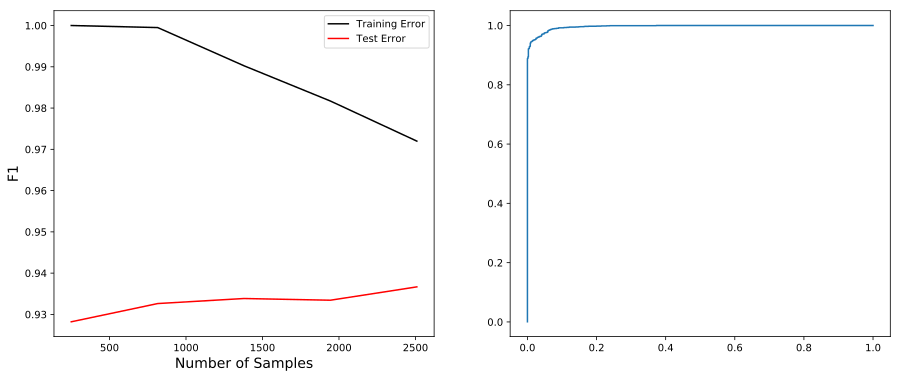

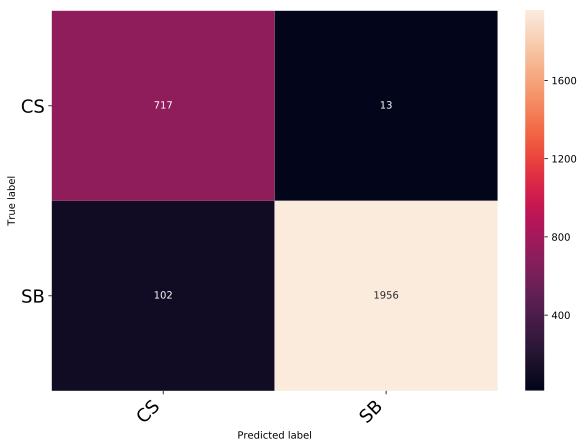

In [137]:
GB_Xtrain_scaled = X_train_scaled.drop(GB_drops, axis = 1)
GB_drops2 = model_dropcols_opt(GB, GB_Xtrain_scaled, y_train, rGB_basef1, 3, True)

GB_Xtrain_scaled2 = X_train_scaled.drop(GB_drops2, axis = 1)
rGB_secondf1 = plot_model(GB, GB_Xtrain_scaled2, y_train)

In [138]:
GB.fit(GB_Xtrain_scaled2, y_train)
GBimportances2 = sorted([(i, j) for i, j in zip(GB_Xtrain_scaled2.columns, GB.feature_importances_)],
       key = lambda x: abs(x[1]), reverse = True)
GB_drops3 = [i[0] for i in GBimportances2 if i[1] == 0]
GB_Xtrain_scaled3 = GB_Xtrain_scaled2.drop(GB_drops3, axis = 1)

In [139]:
GB.fit(GB_Xtrain_scaled3, y_train)
GBimportances3= sorted([(i, j) for i, j in zip(GB_Xtrain_scaled3.columns, GB.feature_importances_)],
       key = lambda x: abs(x[1]), reverse = True)
GB_drops4 = [i[0] for i in GBimportances3 if i[1] < 0.01]

The base LR accuracy is: 0.91176
The base LR f1 is: 0.93781
AUC: 0.9951


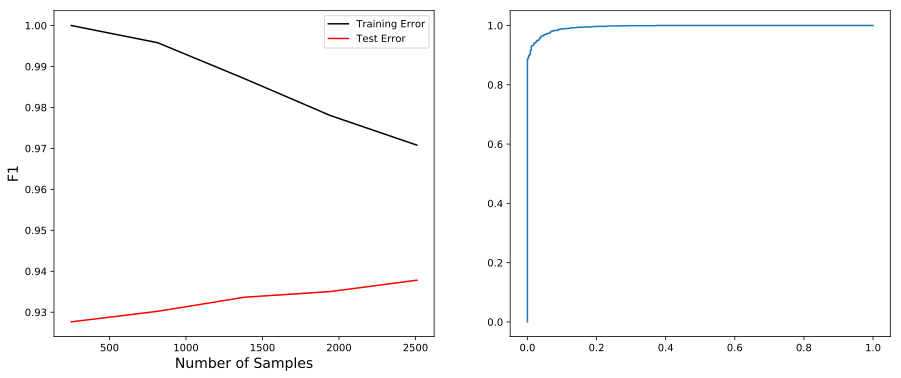

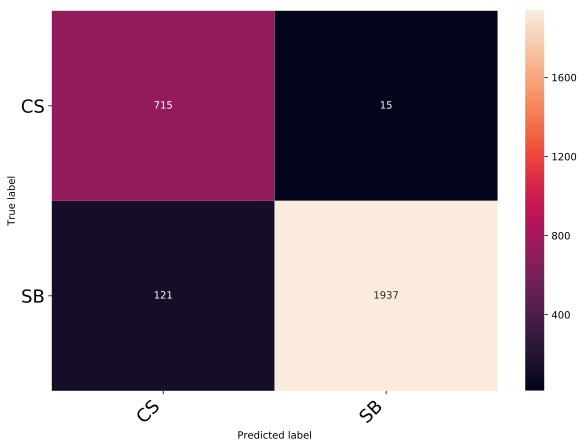

In [140]:
GB_Xtrain_scaled4 = GB_Xtrain_scaled3.drop(GB_drops4, axis = 1)
rGB_thirdf1 = plot_model(GB, GB_Xtrain_scaled4, y_train)

In [ ]:
sorted([(i, j) for i, j in zip(GB_Xtrain_scaled4.columns, GB.feature_importances_)],
       key = lambda x: abs(x[1]), reverse = True)

### Final Model

In [22]:
to_be_dropped = LR_drops + LR_drops2 + LR_colsdrop
X_test_scaled.drop(to_be_dropped, axis = 1, inplace = True)
final_model = LogisticRegression(C = 5.01, random_state = 42)
final_model.fit(LR_Xtrain_scaled3, y_train)
y_predict_train = final_model.predict(LR_Xtrain_scaled3)
y_predict = final_model.predict(X_test_scaled)

Train Set F1: 0.9387


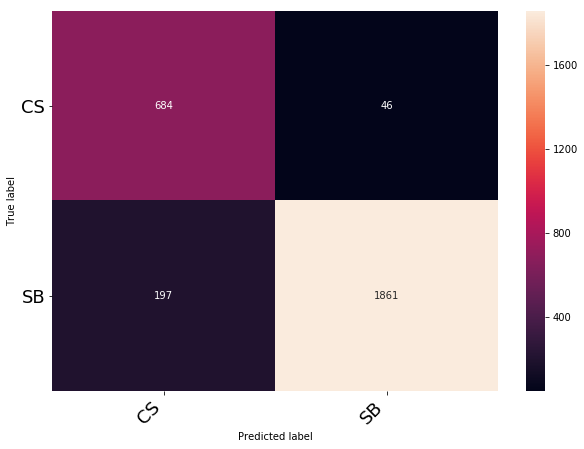

In [23]:
# Training F1
print(f'Train Set F1: {np.round(f1_score(y_train, y_predict_train), 4)}')
conf_mat = confusion_matrix(y_train, y_predict_train)
cm = print_confusion_matrix(conf_mat, ['CS', 'SB'])

Test Set F1: 0.9235


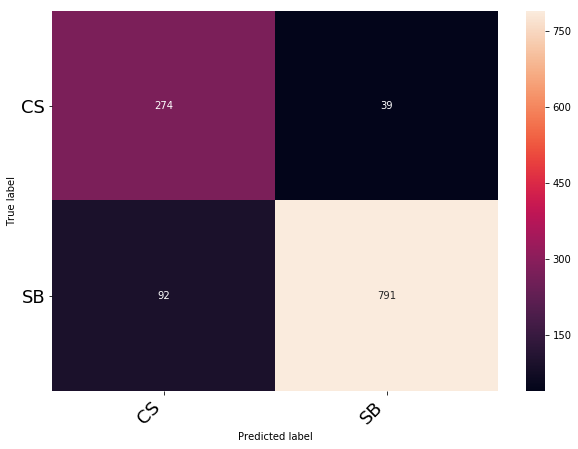

In [24]:
# Test F1
print(f'Test Set F1: {np.round(f1_score(y_test, y_predict), 4)}')
conf_mat = confusion_matrix(y_test, y_predict)
cm = print_confusion_matrix(conf_mat, ['CS', 'SB'])

In [25]:
sorted([(i, j) for i, j in zip(X_test_scaled.columns, final_model.coef_[0])],
       key = lambda x: abs(x[1]), reverse = True)

[('is_rob1', 3.087126252070905),
 ('bc_swing_per', -1.7116413080051254),
 ('bc_o_swing_per', 1.4050151028786453),
 ('bc_contact_per', -1.3142505093831953),
 ('bc_f_strike_per', -1.2532813327502794),
 ('f_strike_per', 1.1950669272505277),
 ('bc_z_swing_per', 0.9752489784135016),
 ('CH_per', -0.8874096056903186),
 ('bc_CH_per', 0.8114455407541802),
 ('contact_per', 0.67883703395338),
 ('bc_SFv', 0.6416390861993438),
 ('bc_SF_per', -0.61058880265218),
 ('bc_zone_per', 0.59942558309714),
 ('is_rob2', 0.5391967875548175),
 ('is_pitcherR', -0.5180976424943954),
 ('CTv', -0.48767122416159286),
 ('bc_CTv', 0.3879351171344056),
 ('startingouts', 0.37345823587894916),
 ('o_contact_per', 0.372738853510919),
 ('o_swing_per', -0.36989553834720024),
 ('bc_z_contact_per', 0.36383477407321174),
 ('CHv', -0.2539776580162576),
 ('CB_per', -0.18508306250317844)]

In [26]:
final_X = X.drop(to_be_dropped, axis = 1)
final_fill_cols = [final_X.columns[i] for i, val in enumerate(final_X.isna().sum()) if val > 0]
final_median_vals = final_X[final_fill_cols].median()
for i, med in enumerate(final_median_vals):
    column_label = final_median_vals.index[i]
    final_X[column_label].fillna(med, inplace = True)


In [33]:
steps = [
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression(C = 5.01, random_state = 42))
]

pipe = Pipeline(steps)
pipe.fit(final_X, y);

with open('basestealing_model.pkl', 'wb') as filename:
    pickle.dump(pipe, filename)

https://www.nssl.noaa.gov/users/brooks/public_html/feda/datasets/expectedruns.html

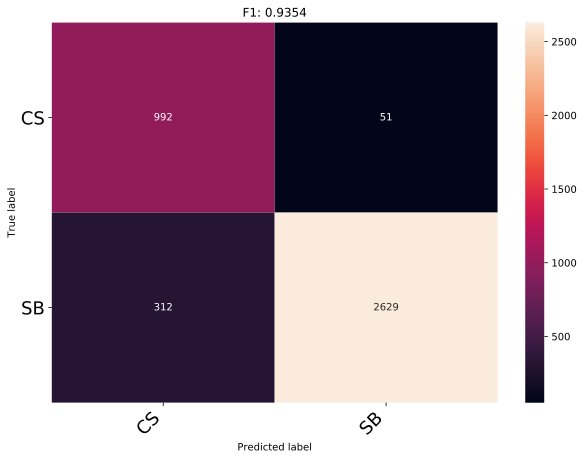

In [129]:
final_ypredict = pipe.predict(final_X)
conf_mat = confusion_matrix(y, final_ypredict)
cm = print_confusion_matrix(conf_mat, ['CS', 'SB'])
plt.title(f'F1: {np.round(f1_score(y, final_ypredict), 4)}');

In [130]:
cm.savefig('confusion_matrix', dpi = 400, transparent = True)

In [29]:
expected_runs = {
    (0, 0, 0, 0): 0.49,
    (0, 1, 0, 0): 0.88,
    (0, 0, 1, 0): 1.13,
    (0, 1, 1, 0): 1.50,
    (0, 0, 0, 1): 1.37,
    (0, 1, 0, 1): 1.75,
    (0, 0, 1, 1): 1.98,
    (0, 1, 1, 1): 2.37,
    (1, 0, 0, 0): 0.26,
    (1, 1, 0, 0): 0.52,
    (1, 0, 1, 0): 0.69,
    (1, 1, 1, 0): 0.92,
    (1, 0, 0, 1): 0.96,
    (1, 1, 0, 1): 1.17,
    (1, 0, 1, 1): 1.40,
    (1, 1, 1, 1): 1.57,
    (2, 0, 0, 0): 0.10,
    (2, 1, 0, 0): 0.23,
    (2, 0, 1, 0): 0.33,
    (2, 1, 1, 0): 0.44,
    (2, 0, 0, 1): 0.38,
    (2, 1, 0, 1): 0.50,
    (2, 0, 1, 1): 0.61,
    (2, 1, 1, 1): 0.76
}

In [30]:
situations = X[['startingouts', 'is_rob1', 'is_rob2', 'is_rob3']].applymap(int).apply(tuple, axis = 1)
saved_runs_df = pd.DataFrame(data = {'key': situations.values, 'true': y.values, 'predict': final_ypredict})
saved_runs_df['expected_value'] = saved_runs_df['key'].apply(lambda x: expected_runs.get(x, 0))
saved_runs_df.head()

,key,true,predict,expected_value
0,"(1, 1, 0, 0)",1,1,0.52
1,"(1, 1, 0, 0)",1,1,0.52
2,"(1, 0, 0, 0)",0,0,0.26
3,"(1, 0, 0, 0)",0,0,0.26
4,"(2, 1, 0, 0)",1,1,0.23


In [31]:
true_neg = saved_runs_df[(saved_runs_df['true'] == 0) & (saved_runs_df['predict'] == 0)]
true_neg['expected_value'].sum()

273.89